In [0]:
spark

In [0]:
# Standard Libraries
from datetime import date, timedelta

# Spark
import pyspark.sql.functions as F
from pyspark.sql import Window
from pyspark.sql.functions import lower, get_json_object, when, coalesce, length
from pyspark.sql.utils import AnalysisException
from pyspark.sql import SparkSession

# Análise descritiva dos dados

**Indicadores relevantes**

In [0]:
df_rest = (spark.table("workspace.default.ab_test_ref")
    .groupBy("is_target")
    .agg(
        F.count("is_target").alias("Freq"),
        (F.count("is_target") * 1.0 / F.sum(F.count("is_target")).over(Window.partitionBy(F.lit(1))) * 100).alias("Percent")
    )
    .withColumn("Percent", F.round("Percent", 2)) 
    .orderBy(F.desc("Freq"))
)

display(df_rest)

is_target,Freq,Percent
target,445925,55.29
control,360542,44.71


In [0]:
df_rest = (spark.table("workspace.default.result_order")
    .groupBy("origin_platform")
    .agg(
        F.count("origin_platform").alias("Freq"),
        (F.count("origin_platform") * 1.0 / F.sum(F.count("origin_platform")).over(Window.partitionBy(F.lit(1))) * 100).alias("Percent")
    )
    .withColumn("Percent", F.round("Percent", 2)) 
    .orderBy(F.desc("Freq"))
)

display(df_rest)

origin_platform,Freq,Percent
IOS,6421698,44.64
ANDROID,5643736,39.23
DESKTOP,2213381,15.39
WINDOWS_PHONE,106245,0.74
null,0,0.0


In [0]:
df_rest = (spark.table("workspace.default.result_order")
    .filter(F.col("is_target").isNotNull())
    .groupBy("is_target", "origin_platform")
    .agg(
        F.count("is_target").alias("Freq"),
        (F.count("is_target") * 1.0 / F.sum(F.count("is_target")).over(Window.partitionBy("is_target")) * 100).alias("Percent")
    )
    .withColumn("Percent", F.round("Percent", 2)) 
    .orderBy(F.col("is_target"), F.desc("Freq"))
)

display(df_rest)

is_target,origin_platform,Freq,Percent
control,IOS,2671309,44.64
control,ANDROID,2353152,39.32
control,DESKTOP,913916,15.27
control,WINDOWS_PHONE,45521,0.76
control,null,2,0.0
target,IOS,3737801,44.74
target,ANDROID,3269173,39.13
target,DESKTOP,1286671,15.4
target,WINDOWS_PHONE,60351,0.72


In [0]:
df_rest = (spark.table("workspace.default.result_order")
    .groupBy("price_range")
    .agg(
        F.count("price_range").alias("Freq"),
        (F.count("price_range") * 1.0 / F.sum(F.count("price_range")).over(Window.partitionBy(F.lit(1))) * 100).alias("Percent")
    )
    .withColumn("Percent", F.round("Percent", 2)) 
    .orderBy(F.desc("Freq"))
)

display(df_rest)

price_range,Freq,Percent
3,5291046,36.78
1,3019261,20.99
2,2922875,20.32
4,2377156,16.53
5,774724,5.39


In [0]:
# Número de pedidos únicos por usuário
df_user_order_counts = (
    spark.table("workspace.default.result_order")
    .filter(F.col("customer_id_order").isNotNull())
    # .filter(F.col("order_total_amount") <= 5000)  # Retirando outilers
    .dropDuplicates(["order_id"])  
    .groupBy("customer_id_order", "is_target")
    .agg(
        F.count("order_id").alias("num_pedidos")  # Pedidos únicos por usuário
    )
)

# Métricas descritivas por grupo A/B
df_result_order_final = (
    spark.table("workspace.default.result_order")
    .filter(F.col("customer_id_order").isNotNull())
    # .filter(F.col("order_total_amount") <= 5000)  
    .dropDuplicates(["order_id"])  
    .groupBy("is_target")
    .agg(
        F.countDistinct("order_id").alias("volume_pedidos"),
        F.avg("order_total_amount").alias("media_valor_pedido"),
        F.stddev("order_total_amount").alias("desvio_padrao_valor_pedido"),
        F.sum("order_total_amount").alias("total_valor_pedido"),
        F.expr("percentile_approx(order_total_amount, 0.5)").alias("mediana_valor_pedido")
    )
    # Join com a tabela de usuários para trazer média e mediana de pedidos por usuário
    .join(
        df_user_order_counts.groupBy("is_target").agg(
            F.avg("num_pedidos").alias("media_pedidos"),
            F.expr("percentile_approx(num_pedidos, 0.5)").alias("mediana_pedidos")
        ),
        on="is_target",
        how="inner"
    )
    # Formatação das colunas para 2 casas decimais
    .withColumn("media_pedidos", F.format_number("media_pedidos", 2))
    .withColumn("mediana_pedidos", F.format_number("mediana_pedidos", 2))
    .withColumn("media_valor_pedido", F.format_number("media_valor_pedido", 2))
    .withColumn("mediana_valor_pedido", F.format_number("mediana_valor_pedido", 2))
    .withColumn("desvio_padrao_valor_pedido", F.format_number("desvio_padrao_valor_pedido", 2))
    .withColumn("total_valor_pedido", F.format_number("total_valor_pedido", 2))
    .select(
        "is_target", 
        "volume_pedidos",
        "media_pedidos",
        "mediana_pedidos",
        "total_valor_pedido",
        "media_valor_pedido",
        "mediana_valor_pedido",
        "desvio_padrao_valor_pedido"
    )
)

display(df_result_order_final)


is_target,volume_pedidos,media_pedidos,mediana_pedidos,total_valor_pedido,media_valor_pedido,mediana_valor_pedido,desvio_padrao_valor_pedido
control,1010738,2.80,1.00,"48,432,203.49",47.92,39.90,146.14
target,1416677,3.18,2.00,"67,729,986.45",47.81,39.90,48.78


**Análise Descritiva do Teste A/B de Cupons**

A análise descritiva dos resultados do teste A/B, que avaliou o impacto de uma estratégia de cupons na retenção de usuários, revelou insights importantes:

- O grupo de teste, que recebeu o cupom, apresentou um volume total de pedidos significativamente maior, com média e mediana também superiores ao grupo de controle. Isso indica que a oferta de cupons contribuiu para aumentar a recorrência de pedidos por usuário — alinhado com o objetivo da campanha.

- Em termos de valor total dos pedidos, o grupo teste e controle apresentou valores muito parecidos na média e na mediana, sugerindo que a estratégia de cupons não gerou pedidos significativamente mais baratos, mas sim mais frequentes.

- Um ponto de atenção é o desvio padrão do valor dos pedidos, muito mais alto no grupo controle (R$ 146,14). Isso pode indicar a presença de outliers ou maior variabilidade no comportamento de compra — o que, por sua vez, pode estar relacionado à ausência de incentivo, deixando o comportamento mais disperso.

- Por fim, esses dados justificam a realização de testes estatísticos para confirmar a significância das diferenças. A análise inicial, porém, indica que o uso de cupons pode ser uma estratégia eficaz para aumentar a frequência de pedidos sem comprometer o valor médio de compra, com potencial impacto positivo no faturamento total da base.


_Conceito de mediana: a mediana é uma medida de tendência central que representa o valor que divide os dados ordenados em duas metades iguais. Em outras palavras, quando os dados são organizados em ordem crescente ou decrescente, a mediana é o valor que está exatamente no meio da distribuição, de modo que 50% dos dados são menores ou iguais a ele e 50% dos dados são maiores ou iguais a ele. A principal vantagem da mediana em relação à média é que ela é robusta a outliers (valores extremos). Isso significa que valores atípicos de valor de pedido, por exemplo, tornando-a uma medida mais representativa para distribuições assimétricas._

In [0]:
# Filtra apenas clientes do grupo 'target'
df_filtrado = (
    df.filter(F.col("is_target") == "target")
      .select("customer_id", "order_id")
      .dropDuplicates()
)

# Contando quantos pedidos distintos cada cliente fez
df_qtd_pedidos = (
    df_filtrado.groupBy("customer_id")
    .agg(F.countDistinct("order_id").alias("qtd_pedidos"))
)

# Classificando os clientes nas faixas de quantidade de pedidos
df_faixas = df_qtd_pedidos.withColumn(
    "faixa_pedidos",
    F.when(F.col("qtd_pedidos").between(1, 3), "1.Entre 1 a 3")
     .when(F.col("qtd_pedidos").between(4, 5), "2.Entre 4 e 5")
     .when(F.col("qtd_pedidos").between(6, 10), "3.Entre 6 e 10")
     .when(F.col("qtd_pedidos").between(11, 20), "4.Entre 11 e 20")
     .when(F.col("qtd_pedidos").between(21, 50), "5.Entre 21 e 50")
     .when(F.col("qtd_pedidos") > 50, "6.Acima de 50")
)

# Contando quantos clientes estão em cada faixa
df_resultado = (
    df_faixas.groupBy("faixa_pedidos")
    .agg(F.count("*").alias("qtd_clientes"))
)

# Calculo do percentual de clientes por faixa
window_total = Window.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

df_final = df_resultado.withColumn(
    "pct_clientes",
    F.round(
        F.col("qtd_clientes") * 100.0 / F.sum("qtd_clientes").over(window_total), 2
    )
).orderBy("faixa_pedidos")

df_final.display()

faixa_pedidos,qtd_clientes,pct_clientes
1.Entre 1 a 3,328913,73.79
2.Entre 4 e 5,52014,11.67
3.Entre 6 e 10,44086,9.89
4.Entre 11 e 20,17004,3.81
5.Entre 21 e 50,3619,0.81
6.Acima de 50,108,0.02


In [0]:
# Filtra apenas clientes do grupo 'control'
df_filtrado = (
    df.filter(F.col("is_target") == "control")
      .select("customer_id", "order_id")
      .dropDuplicates()
)

# Contando quantos pedidos distintos cada cliente fez
df_qtd_pedidos = (
    df_filtrado.groupBy("customer_id")
    .agg(F.countDistinct("order_id").alias("qtd_pedidos"))
)

# Classificando os clientes nas faixas de quantidade de pedidos
df_faixas = df_qtd_pedidos.withColumn(
    "faixa_pedidos",
    F.when(F.col("qtd_pedidos").between(1, 3), "1.Entre 1 a 3")
     .when(F.col("qtd_pedidos").between(4, 5), "2.Entre 4 e 5")
     .when(F.col("qtd_pedidos").between(6, 10), "3.Entre 6 e 10")
     .when(F.col("qtd_pedidos").between(11, 20), "4.Entre 11 e 20")
     .when(F.col("qtd_pedidos").between(21, 50), "5.Entre 21 e 50")
     .when(F.col("qtd_pedidos") > 50, "6.Acima de 50")
)

# Contando quantos clientes estão em cada faixa
df_resultado = (
    df_faixas.groupBy("faixa_pedidos")
    .agg(F.count("*").alias("qtd_clientes"))
)

# Calculo do percentual de clientes por faixa
window_total = Window.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

df_final = df_resultado.withColumn(
    "pct_clientes",
    F.round(
        F.col("qtd_clientes") * 100.0 / F.sum("qtd_clientes").over(window_total), 2
    )
).orderBy("faixa_pedidos")

df_final.display()

faixa_pedidos,qtd_clientes,pct_clientes
1.Entre 1 a 3,281893,78.21
2.Entre 4 e 5,34981,9.71
3.Entre 6 e 10,29695,8.24
4.Entre 11 e 20,11395,3.16
5.Entre 21 e 50,2386,0.66
6.Acima de 50,64,0.02


Observa-se que a grande maioria dos usuários, tanto no grupo target quanto no control , realizou entre 1 e 3 pedidos, o que indica um comportamento de uso pontual ou ocasional do serviço.

No entanto, o grupo target (que recebeu o cupom) apresentou maior volume de usuários que realizam entre 6 e 20 pedidos, se comparado ao grupo controle.


Apesar de sutis, esses resultados sugerem que o cupom pode ter incentivado um maior engajamento de parte dos usuários, levando-os a realizar mais pedidos do que o grupo controle.

Essa tendência, ainda que não drástica, pode indicar um potencial de impacto positivo do cupom sobre a frequência de compra.

In [0]:
from pyspark.sql import functions as F
from pyspark.sql import Window

# Filtra pedidos distintos do grupo target
df_pedidos = (
    df.filter(F.col("is_target") == "target")
      .select("order_id", "order_total_amount")
      .dropDuplicates()
)

# Classificando cada pedido em uma faixa de valor
df_faixas = df_pedidos.withColumn(
    "faixa_valor",
    F.when((F.col("order_total_amount") >= 0) & (F.col("order_total_amount") <= 30), "1. Até 30")
     .when((F.col("order_total_amount") > 30) & (F.col("order_total_amount") <= 50), "2. Entre 31 e 50")
     .when((F.col("order_total_amount") > 50) & (F.col("order_total_amount") <= 80), "3. Entre 51 e 80")
     .when((F.col("order_total_amount") > 80) & (F.col("order_total_amount") <= 100), "4. Entre 81 e 100")
     .when((F.col("order_total_amount") > 100) & (F.col("order_total_amount") <= 200), "5. Entre 101 e 200")
     .when((F.col("order_total_amount") > 200) & (F.col("order_total_amount") <= 500), "6. Entre 201 e 500")
     .when(F.col("order_total_amount") > 500, "7. Acima de 500")
)

# Contando quantos pedidos distintos há por faixa
df_grouped = df_faixas.groupBy("faixa_valor").agg(
    F.countDistinct("order_id").alias("qtd_pedidos")
)

# Calculo do percentual de pedidos por faixa
window_total = Window.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

df_final = df_grouped.withColumn(
    "pct_pedidos",
    F.round(
        F.col("qtd_pedidos") * 100.0 / F.sum("qtd_pedidos").over(window_total),
        2
    )
).orderBy("faixa_valor")


df_final.display()

faixa_valor,qtd_pedidos,pct_pedidos
1. Até 30,458867,32.39
2. Entre 31 e 50,491718,34.71
3. Entre 51 e 80,307993,21.74
4. Entre 81 e 100,69914,4.94
5. Entre 101 e 200,79170,5.59
6. Entre 201 e 500,8763,0.62
7. Acima de 500,252,0.02


In [0]:
from pyspark.sql import functions as F
from pyspark.sql import Window

# Filtra pedidos distintos do grupo target
df_pedidos = (
    df.filter(F.col("is_target") == "control")
      .select("order_id", "order_total_amount")
      .dropDuplicates()
)

# Classificando cada pedido em uma faixa de valor
df_faixas = df_pedidos.withColumn(
    "faixa_valor",
    F.when((F.col("order_total_amount") >= 0) & (F.col("order_total_amount") <= 30), "1. Até 30")
     .when((F.col("order_total_amount") > 30) & (F.col("order_total_amount") <= 50), "2. Entre 31 e 50")
     .when((F.col("order_total_amount") > 50) & (F.col("order_total_amount") <= 80), "3. Entre 51 e 80")
     .when((F.col("order_total_amount") > 80) & (F.col("order_total_amount") <= 100), "4. Entre 81 e 100")
     .when((F.col("order_total_amount") > 100) & (F.col("order_total_amount") <= 200), "5. Entre 101 e 200")
     .when((F.col("order_total_amount") > 200) & (F.col("order_total_amount") <= 500), "6. Entre 201 e 500")
     .when(F.col("order_total_amount") > 500, "7. Acima de 500")
)

# Contando quantos pedidos distintos há por faixa
df_grouped = df_faixas.groupBy("faixa_valor").agg(
    F.countDistinct("order_id").alias("qtd_pedidos")
)

# Calculo do percentual de pedidos por faixa
window_total = Window.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

df_final = df_grouped.withColumn(
    "pct_pedidos",
    F.round(
        F.col("qtd_pedidos") * 100.0 / F.sum("qtd_pedidos").over(window_total),
        2
    )
).orderBy("faixa_valor")


df_final.display()

faixa_valor,qtd_pedidos,pct_pedidos
1. Até 30,325938,32.25
2. Entre 31 e 50,352194,34.85
3. Entre 51 e 80,220267,21.79
4. Entre 81 e 100,49976,4.94
5. Entre 101 e 200,56098,5.55
6. Entre 201 e 500,6100,0.6
7. Acima de 500,165,0.02


A distribuição do valor total dos pedidos por faixa é praticamente idêntica entre os grupos target e control, o que indica que o envio do cupom não teve impacto significativo no ticket médio das compras.

Em ambos os grupos, cerca de 67% do valor total está concentrado em pedidos de até R$ 50, sendo a faixa entre R$ 31 e R$ 50 a mais representativa (35%).

As faixas de valor mais altas (acima de R$ 200) representam apenas 1% do total em cada grupo, reforçando o comportamento de pedidos de baixo valor na base analisada.

Mesmo com uma base maior no grupo target, a distribuição percentual se manteve proporcional, sugerindo que o cupom não alterou o padrão de valor por pedido, mas possivelmente apenas o volume total de pedidos.

# Análise estatística - Parte I

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import numpy as np
from plotnine import *
import geopandas as gpd
import plotly.express as px
from scipy.stats import shapiro, mannwhitneyu
from plotnine import *

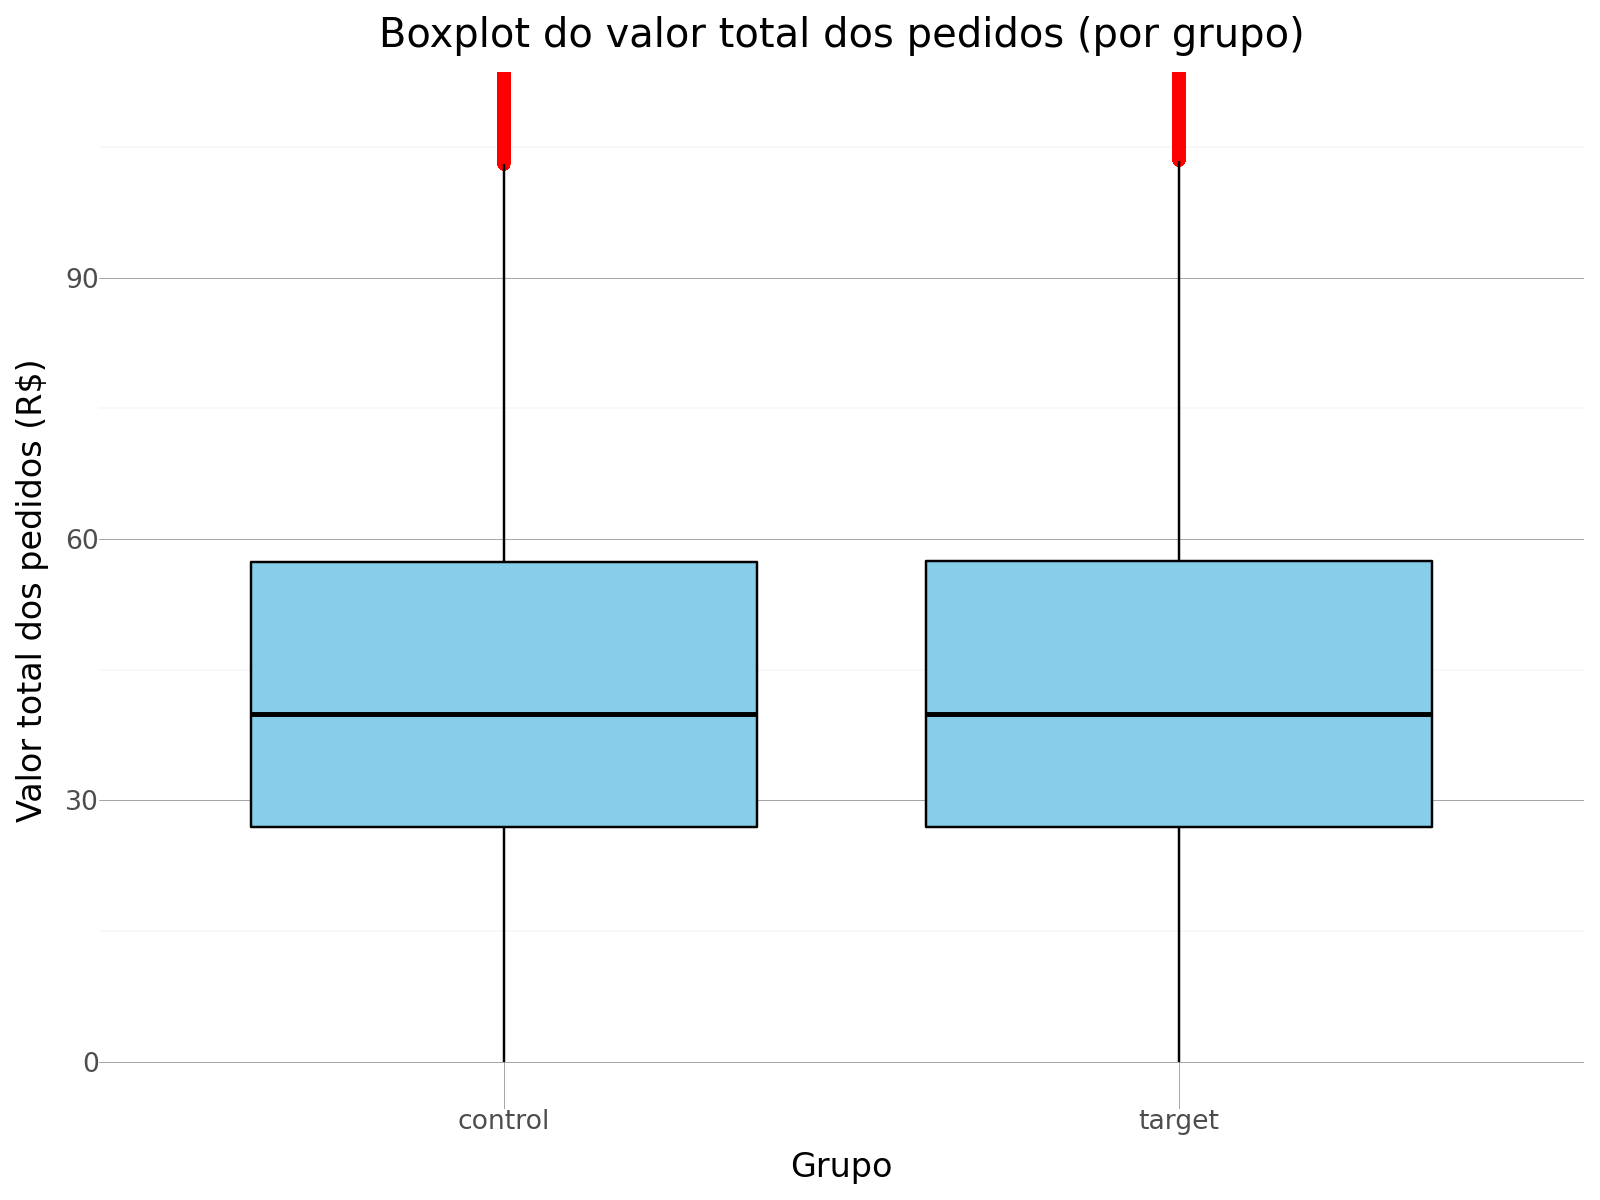

In [0]:
# Preparando os dados (remover outliers e garantir 1 linha por pedido)
df_pandas = (
    spark.table("workspace.default.result_order")
    .filter(F.col("customer_id_order").isNotNull())
    .filter(F.col("order_total_amount") <= 5000)
    .dropDuplicates(["order_id"])
    .select("is_target", "order_total_amount")
    .toPandas()
)

# Limite superior (P95), para melhor vizualização gráfica
limite = np.percentile(df_pandas['order_total_amount'], 95)


(
    ggplot(df_pandas, aes(x='is_target', y='order_total_amount')) +
    geom_boxplot(fill="skyblue", color="black", outlier_color="red") +
    coord_cartesian(ylim=(0, limite)) +
    labs(
        title="Boxplot do valor total dos pedidos (por grupo)",
        x="Grupo",
        y="Valor total dos pedidos (R$)"
    ) +
    theme_minimal(base_size=12) +
    theme(
        figure_size=(8, 6),
        panel_background=element_rect(fill='white', color='white'),
        plot_background=element_rect(fill='white', color='white'),
        panel_grid_major=element_line(color="gray", size=0.25),
        panel_grid_minor=element_line(color="lightgray", size=0.1)
    )
)

Analisando o gráfico acima podemos ver que:

A mediana (linha preta central) dos dois grupos é praticamente igual, indicando que o valor mais comum dos pedidos não mudou significativamente com a aplicação do cupom.
Os dois grupos apresentam faixas interquartis semelhantes (caixa azul), o que sugere que o comportamento de gasto é similar para a maioria dos usuários, com ou sem cupom.
Os pontos vermelhos acima dos bigodes representam valores atípicos de pedido (acima de R$ 100). O número de outliers é similar, reforçando a ideia de comportamento de consumo comparável entre os grupos, mesmo nos extremos.

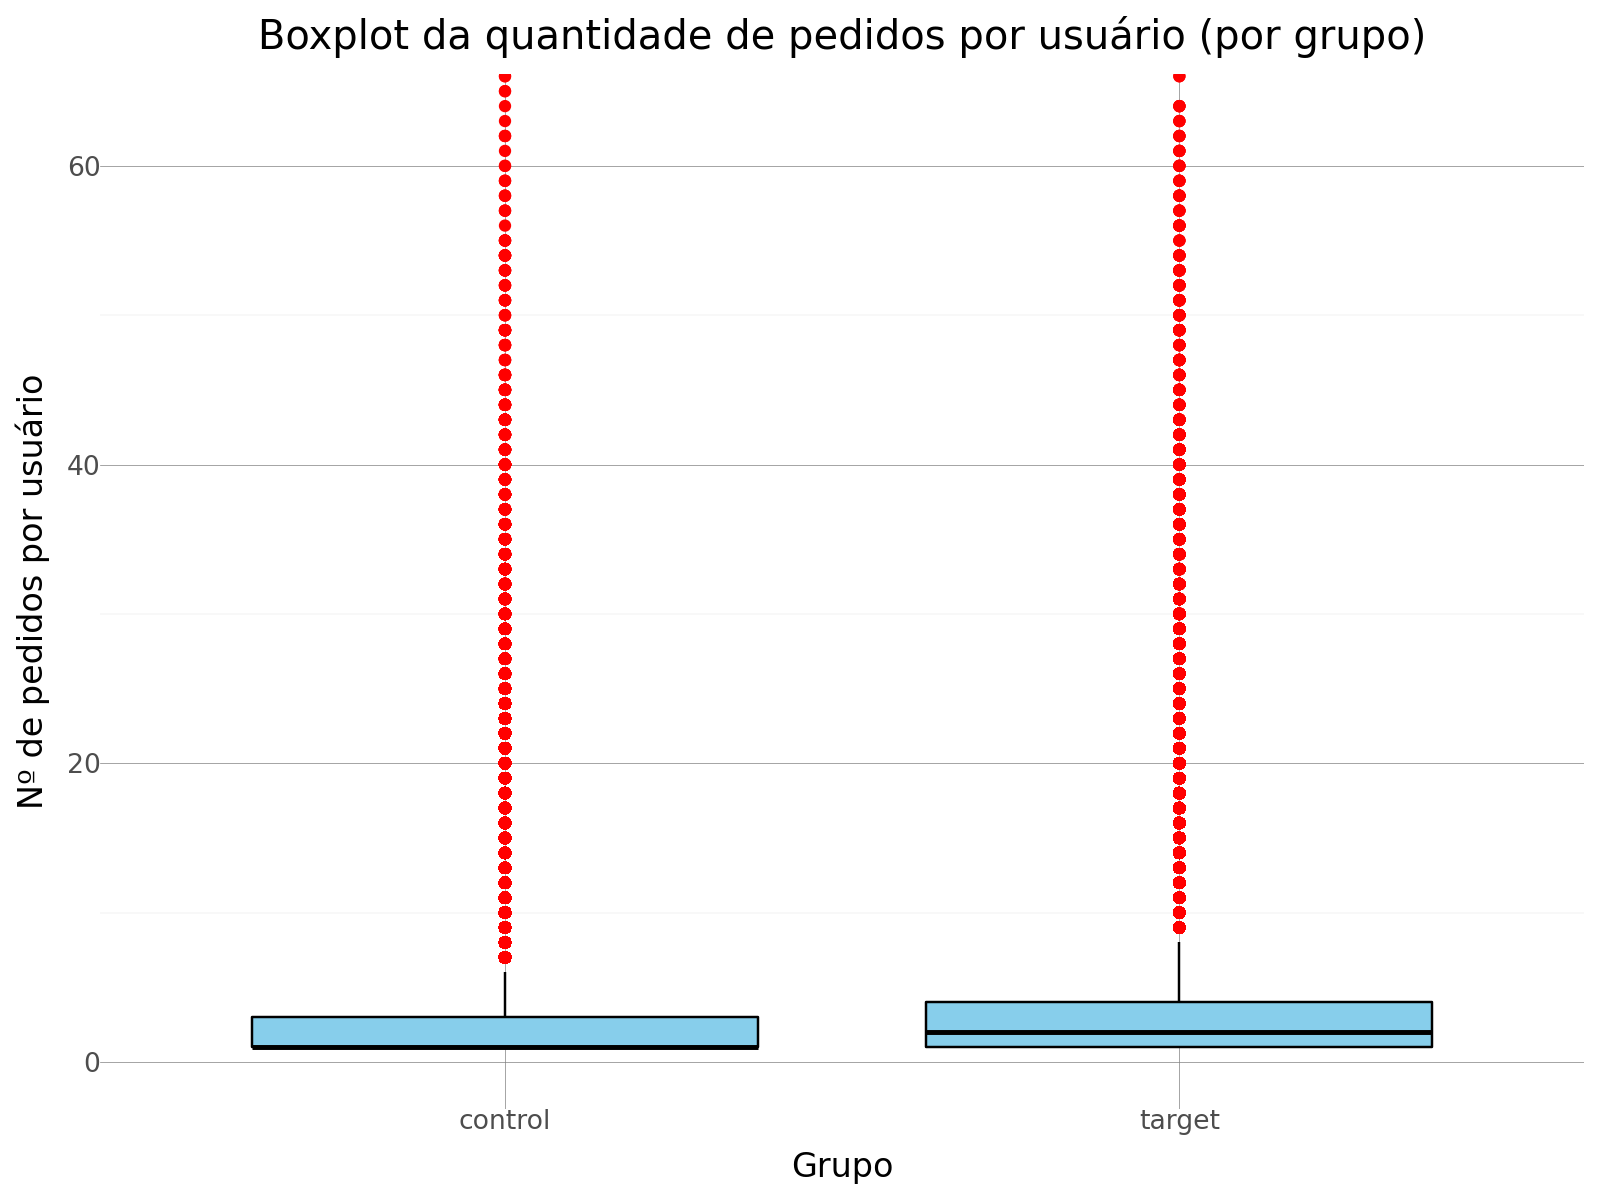

In [0]:
# Preparando os dados (remover outliers e garantir 1 linha por pedido)
df_user_counts = (
    spark.table("workspace.default.result_order")
    .filter(F.col("customer_id_order").isNotNull())
    .filter(F.col("order_total_amount") <= 5000)
    .dropDuplicates(["order_id"])
    .groupBy("customer_id_order", "is_target")
    .agg(F.count("order_id").alias("num_pedidos"))
).toPandas()

# Limite superior (P80), para melhor vizualização gráfica
limite = np.percentile(df_pandas['order_total_amount'], 80)


(
    ggplot(df_user_counts, aes(x='is_target', y='num_pedidos')) +
    geom_boxplot(fill="skyblue", color="black", outlier_color="red") +
    coord_cartesian(ylim=(0, limite)) +
    labs(
        title="Boxplot da quantidade de pedidos por usuário (por grupo)",
        x="Grupo",
        y="Nº de pedidos por usuário"
    ) +
    theme_minimal(base_size=12) +
    theme(
        figure_size=(8, 6),
        panel_background=element_rect(fill='white', color='white'),
        plot_background=element_rect(fill='white', color='white'),
        panel_grid_major=element_line(color="gray", size=0.25),
        panel_grid_minor=element_line(color="lightgray", size=0.1)
    )
)

Analisando o boxplot, temos:

- A maioria dos usuários em ambos os grupos realiza poucos pedidos — a mediana está em torno de 1 ou 2 pedidos, o que indica que 50% dos usuários fizeram no máximo essa quantidade.

- Existe uma alta concentração de valores baixos (como 1, 2, 3 pedidos), e a distribuição é assimétrica à direita, ou seja, há poucos usuários com comportamento muito diferente do restante (os chamados outliers).

- Os outliers, representados pelos pontos vermelhos, mostram usuários que fizeram um número de pedidos muito acima da média, chegando a mais de 60 pedidos em ambos os grupos.

- Porém, o grupo target (teste) apresenta uma distribuição ligeiramente mais elevada, com outliers mais extremos do que no grupo controle, indicando que alguns usuários responderam fortemente ao cupom.
Essa diferença de dispersão reforça o que vimos na análise descritiva: o cupom parece estimular maior engajamento em uma parte dos usuários.

Para validar se essas diferenças observadas são estatisticamente significativas será necessário aplicar testes estatísticos apropriados.

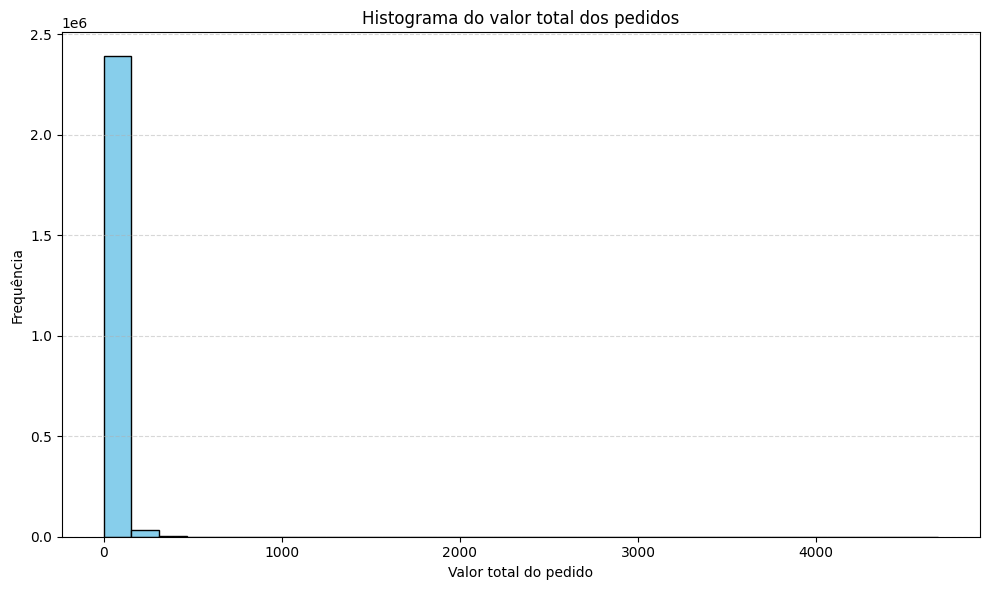

In [0]:
df_valores_pedidos = (
    spark.table("workspace.default.result_order")
    .filter(F.col("customer_id_order").isNotNull())
    .filter(F.col("order_total_amount") <= 5000)
    .dropDuplicates(["order_id"])
    .select("is_target", "order_total_amount")
    .toPandas()
)


plt.figure(figsize=(10, 6))
plt.hist(df_valores_pedidos['order_total_amount'], bins=30, color='skyblue', edgecolor='black')
plt.title("Histograma do valor total dos pedidos")
plt.xlabel("Valor total do pedido")
plt.ylabel("Frequência")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

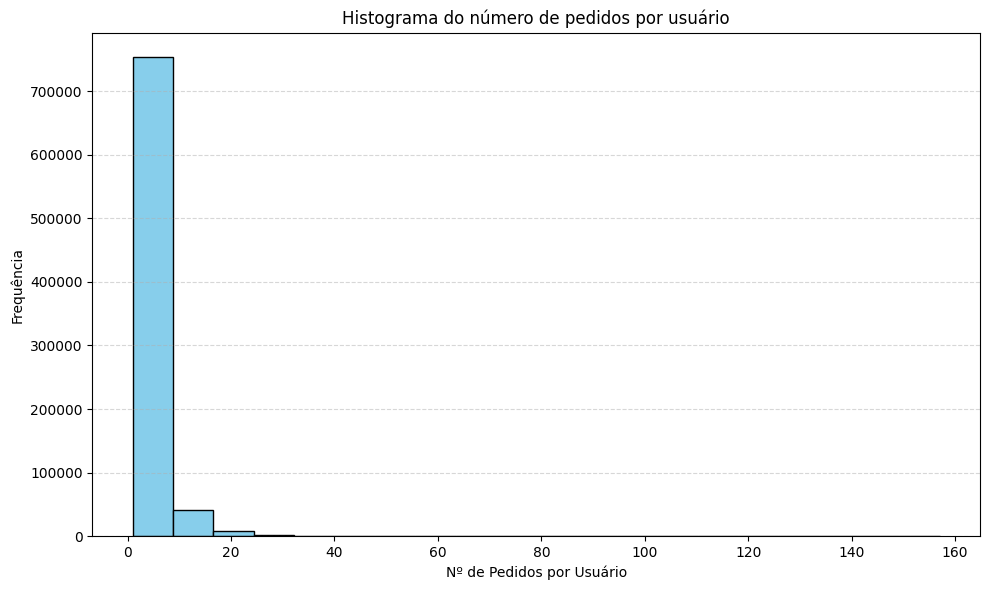

In [0]:
df_user_counts = (
    spark.table("workspace.default.result_order")
    .filter(F.col("customer_id_order").isNotNull())
    .filter(F.col("order_total_amount") <= 5000)
    .dropDuplicates(["order_id"])
    .groupBy("customer_id_order", "is_target")
    .agg(F.count("order_id").alias("num_pedidos"))
).toPandas()

plt.figure(figsize=(10, 6))
plt.hist(df_user_counts['num_pedidos'], bins=20, color='skyblue', edgecolor='black')
plt.title("Histograma do número de pedidos por usuário")
plt.xlabel("Nº de Pedidos por Usuário")
plt.ylabel("Frequência")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Perceba que nos dois histogramas, a distribuição dos valores é muito assimétrica. Isso indica que não temos uma distribuição homogênea dos dados e provavelmente os dados não terão distribuição normal.

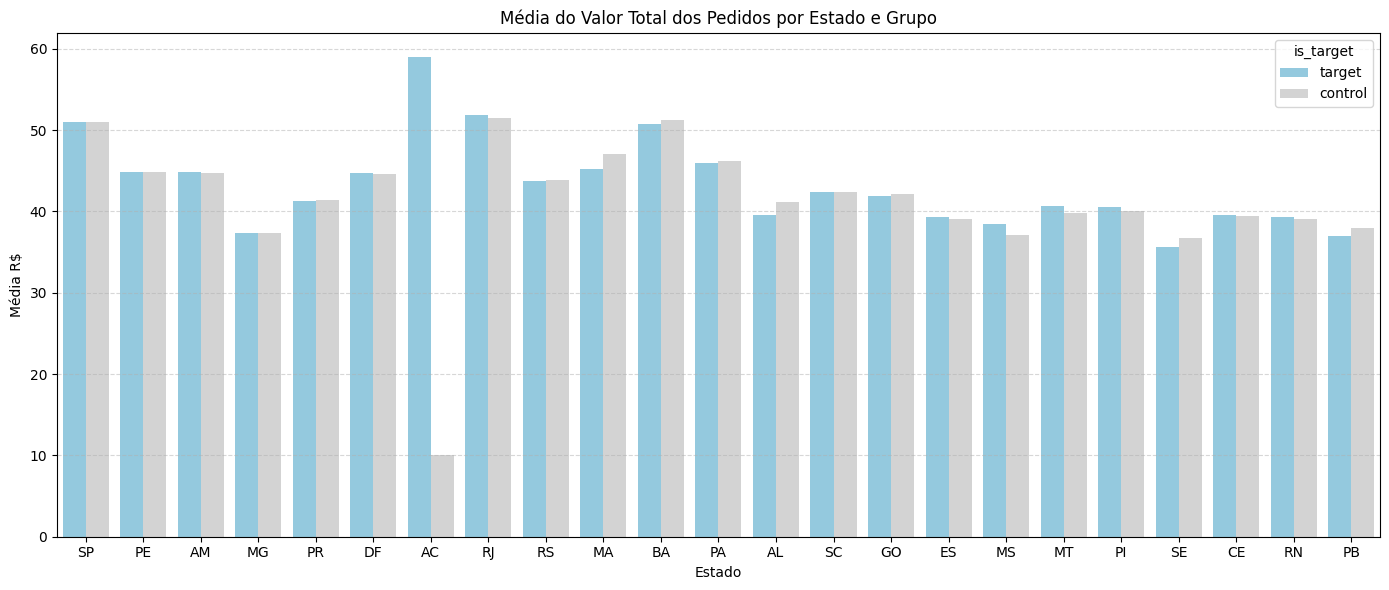

In [0]:
df_mapa = (
    spark.table("workspace.default.result_order")
    .filter(F.col("delivery_address_state").isNotNull())
    .filter(F.col("order_total_amount").isNotNull())
    .filter(F.col("order_total_amount") <= 5000)
    .dropDuplicates(["order_id"])  # garantir 1 linha por pedido
    .groupBy("is_target", "delivery_address_state")
    .agg(F.avg("order_total_amount").alias("media_order_total"))
    .toPandas()
)


# Ordenar os estados pela média
df_mapa_sorted = df_mapa.sort_values(by="media_order_total", ascending=False)

# Define a figura
plt.figure(figsize=(14, 6))

# Cria gráfico de barras com separação por grupo (control / target)
sns.barplot(
    data=df_mapa_sorted,
    x="delivery_address_state",
    y="media_order_total",
    hue="is_target",
    palette={"target": "skyblue", "control": "lightgray"}
)

plt.title("Média do Valor Total dos Pedidos por Estado e Grupo", fontsize=12)
plt.xlabel("Estado")
plt.ylabel("Média R$")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

- No gráfico acima podemos ver que a diferença entre os grupos é pequena na maioria dos estados, o que confirma o que já tínhamos observado anteriormente: parece não haver diferença estatística significativa no valor dos pedidos entre os grupos.

- A média dos pedidos varia consideravelmente entre os estados, o que indica que o comportamento de consumo regional pode ter mais peso do que o cupom em si, quando se trata de valor dos pedidos.

- Acre (AC): é o único estado com uma diferença extremamente alta entre os grupos — o grupo target tem uma média de pedidos quase 6 vezes maior. Isso pode indicar outliers (valores muito altos) no grupo target, onde os usuários impactam fortemente a média.


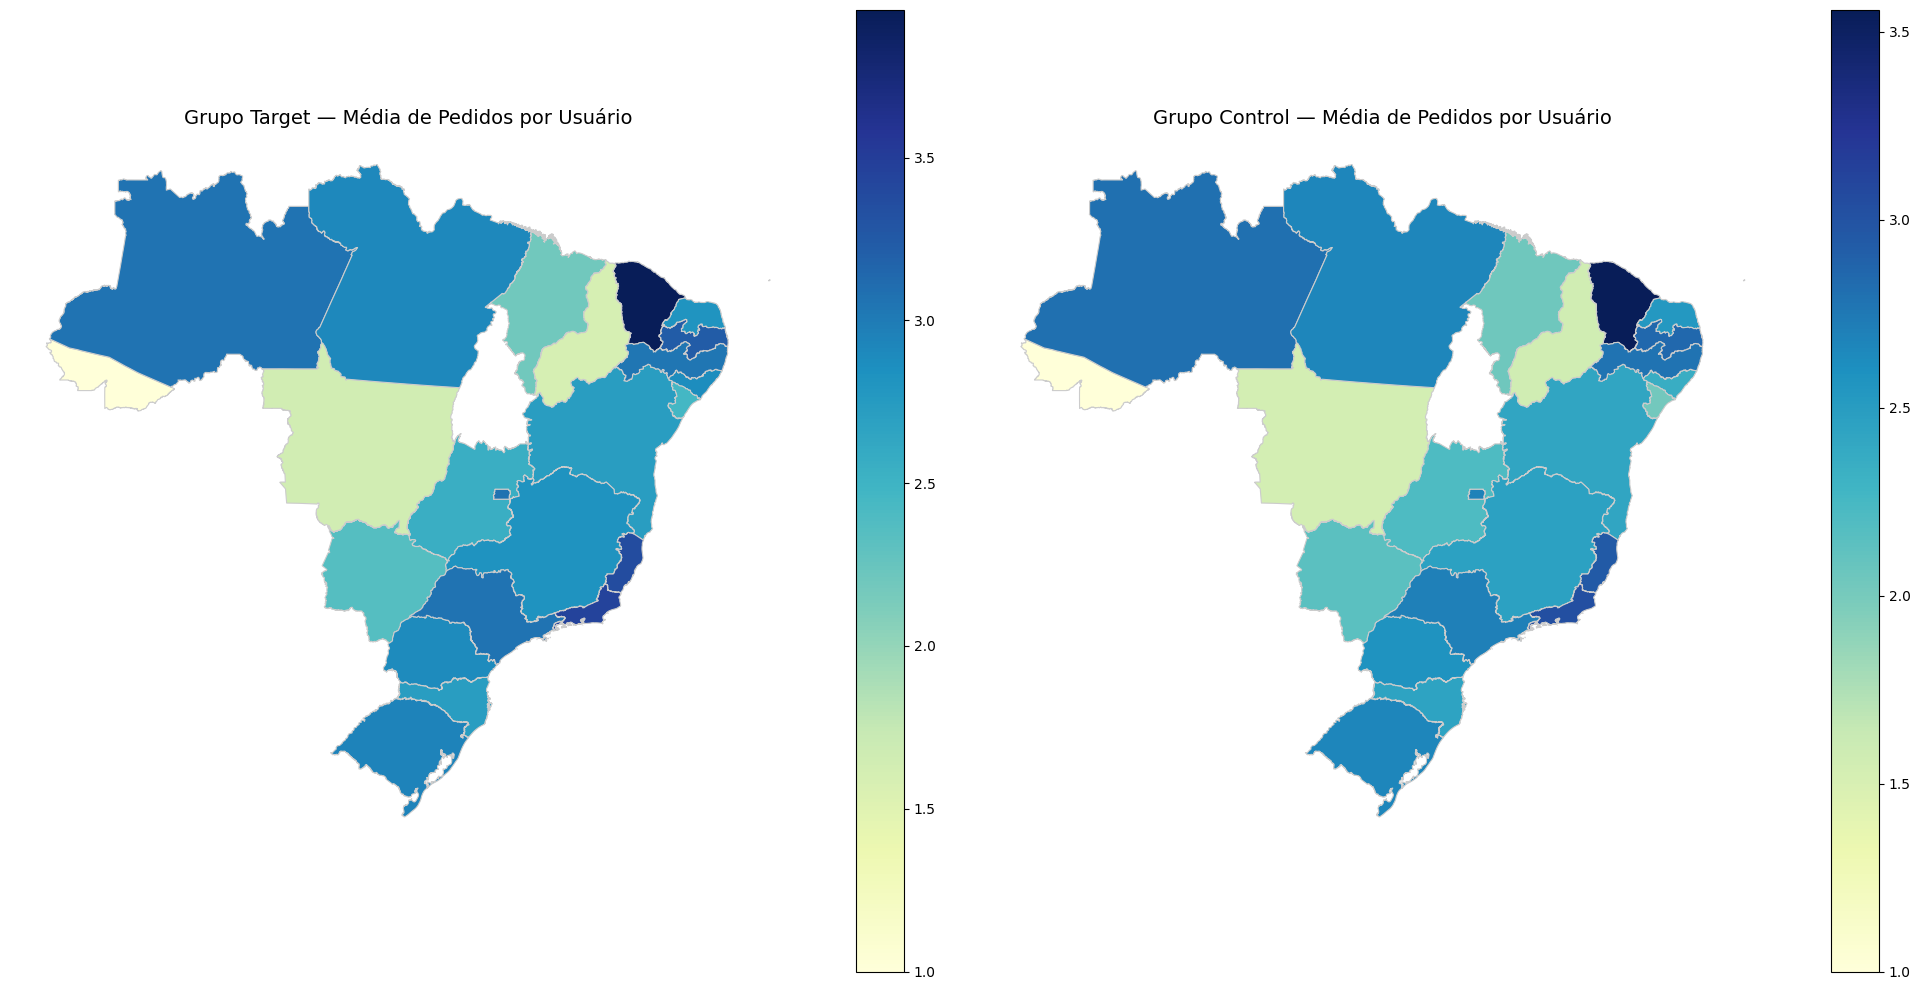

In [0]:
# Imports necessários
import geopandas as gpd
import matplotlib.pyplot as plt
import pyspark.sql.functions as F

# Caminho para o shapefile do Brasil (formato GeoJSON)
path_geojson = "/Volumes/workspace/default/brazil-states/brazil-states.geojson"

# Leitura do shapefile
estados_br = gpd.read_file(path_geojson)
estados_br["UF"] = estados_br["sigla"]

# ---------------------------------------
# Cálculo da MÉDIA DE PEDIDOS POR USUÁRIO
# ---------------------------------------
df_user_order_counts = (
    spark.table("workspace.default.result_order")
    .filter(F.col("customer_id_order").isNotNull())
    .filter(F.col("delivery_address_state").isNotNull())
    .filter(F.col("order_id").isNotNull())
    .dropDuplicates(["order_id"])  # garante 1 linha por pedido
    .groupBy("customer_id_order", "delivery_address_state", "is_target")
    .agg(F.count("order_id").alias("num_pedidos"))
    .toPandas()
)

# Agrupar por estado e grupo para obter a média de pedidos por usuário
df_mapa = (
    df_user_order_counts
    .groupby(["delivery_address_state", "is_target"])
    .agg(media_pedidos=("num_pedidos", "mean"))
    .reset_index()
)

# Garantir estado em UPPERCASE
df_mapa["delivery_address_state"] = df_mapa["delivery_address_state"].str.upper()

# Separar grupos
df_target = df_mapa[df_mapa["is_target"] == "target"]
df_control = df_mapa[df_mapa["is_target"] == "control"]

# Join com shapefile
mapa_target = estados_br.merge(df_target, how="left", left_on="UF", right_on="delivery_address_state")
mapa_control = estados_br.merge(df_control, how="left", left_on="UF", right_on="delivery_address_state")

# ---------------------------------------
# Plotagem dos dois mapas lado a lado
# ---------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Mapa TARGET
mapa_target.plot(
    column="media_pedidos",
    cmap="YlGnBu",
    linewidth=0.8,
    ax=axes[0],
    edgecolor="0.8",
    legend=True
)
axes[0].set_title("Grupo Target — Média de Pedidos por Usuário", fontsize=14)
axes[0].axis("off")

# Mapa CONTROL
mapa_control.plot(
    column="media_pedidos",
    cmap="YlGnBu",
    linewidth=0.8,
    ax=axes[1],
    edgecolor="0.8",
    legend=True
)
axes[1].set_title("Grupo Control — Média de Pedidos por Usuário", fontsize=14)
axes[1].axis("off")

plt.tight_layout()
plt.show()


O que o gráfico acima nos mostra:

- Escala de cores: quanto mais escuro o azul, maior a média de pedidos por usuário naquele estado.
- Aumento geral nos pedidos no grupo Target em vários estados, como: SP, RJ, RS, PR, BA, PE, CE, o mapa Target está mais escuro que o Control. Isso indica que os usuários que receberam cupom estão pedindo mais que os do grupo controle.

Reforça o achado anterior: o cupom aumentou a frequência, mesmo que o valor médio dos pedidos não tenha subido.


Conclusões:
- A campanha foi eficaz em aumentar a frequência de pedidos em boa parte do país, com efeitos mais visíveis em estados populosos ou com alta concentração digital.
- Porém, nem todas as regiões responderam da mesma forma. Isso abre espaço para:
- Estratégias de customização regional de cupons.
- Testes A/B por cluster geográfico.
- Ajustes de verba e foco nas regiões que respondem melhor.

In [0]:
df_pedidos = (
    spark.table("workspace.default.result_order")
    .filter(F.col("order_id").isNotNull())
    .filter(F.col("order_total_amount").isNotNull())
    .filter(F.col("order_total_amount") <= 5000)  # remove outliers
    .dropDuplicates(["order_id"])
    .select("customer_id_order", "is_target", "order_id", "order_total_amount")
    .toPandas()
)

# Teste de normalidade (Shapiro-Wilk)
stat_shapiro, p_shapiro = shapiro(df_pedidos["order_total_amount"])
print(f"Shapiro-Wilk Test: W = {stat_shapiro:.5f}, p-value = {p_shapiro:.5f}")

Shapiro-Wilk Test: W = 0.69756, p-value = 0.00000


/databricks/python/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.


Antes de iniciar qualquer teste, devemos primeiro analisar a distruição da variável de interesse, que no caso acima é o valor total dos pedidos:

O Teste de normalidade (Shapiro-Wilk) é usado para avaliar se uma variável segue uma distribuição normal.
Hispóteses do teste:

- Hipótese Nula (H₀): Os dados seguem uma distribuição normal.
- Hipótese Alternativa (H₁): Os dados não seguem uma distribuição normal.


Como interpretar o p-valor:
- p > 0.05 → Não rejeitamos H₀ → A distribuição pode ser considerada normal
- p ≤ 0.05 → Rejeitamos H₀ → Os dados não seguem uma distribuição normal

O p-valor foi menor que 0.05. De acordo com o resultado do teste, a um nível de 95% de confiança, os dados não seguem uma distribuição normal. Portanto o teste não paramétrico de Wilcoxon-Mann-Whitney é o mais adequado.

In [0]:
df_pedidos = (
    spark.table("workspace.default.result_order")
    .filter(F.col("order_id").isNotNull())
    .filter(F.col("customer_id_order").isNotNull())
    .dropDuplicates(["order_id"])
    .select("customer_id_order", "is_target", "order_id")
    .toPandas()
)

# Agrupando por usuário para contar o número de pedidos
df_volume_usuarios = (
    df_pedidos
    .groupby(["customer_id_order", "is_target"])
    .agg(num_pedidos=("order_id", "count"))
    .reset_index()
)

# Teste de normalidade (Shapiro-Wilk)
stat_shapiro, p_shapiro = shapiro(df_volume_usuarios["num_pedidos"])
print(f"Shapiro-Wilk Test para número de pedidos por usuário: W = {stat_shapiro:.5f}, p-value = {p_shapiro:.5f}")

Shapiro-Wilk Test para número de pedidos por usuário: W = 0.56490, p-value = 0.00000


/databricks/python/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.


Variável de interesse: volume de pedidos por usuário

Hipóteses do Teste de normalidade:

- Hipótese Nula (H₀): Os dados seguem uma distribuição normal.
- Hipótese Alternativa (H₁): Os dados não seguem uma distribuição normal.


Como interpretar o p-valor:
- p > 0.05 → Não rejeitamos H₀ → A distribuição pode ser considerada normal
- p ≤ 0.05 → Rejeitamos H₀ → Os dados não seguem uma distribuição normal

O p-valor foi menor que 0.05. De acordo com o resultado do teste, a um nível de 95% de confiança, os dados não seguem uma distribuição normal. Portanto o teste não paramétrico de Wilcoxon-Mann-Whitney é o mais adequado.

In [0]:

# Primeiro vamos analisar se existe diferneça entre os dois grupos em relação ao valor total dos pedidos.

df_pedidos = (
    spark.table("workspace.default.result_order")
    .filter(F.col("order_id").isNotNull())
    .filter(F.col("order_total_amount").isNotNull())
    .filter(F.col("order_total_amount") <= 5000)  # remove outliers
    .dropDuplicates(["order_id"])
    .select("customer_id_order", "is_target", "order_id", "order_total_amount")
    .toPandas()
)

grupo_control = df_pedidos[df_pedidos["is_target"] == "control"]["order_total_amount"]
grupo_target = df_pedidos[df_pedidos["is_target"] == "target"]["order_total_amount"]

# Teste de Wilcoxon-Mann-Whitney
stat_wilcoxon, p_wilcoxon = mannwhitneyu(grupo_control, grupo_target, alternative="two-sided")
print(f"Mann-Whitney Test: U = {stat_wilcoxon}, p-value = {p_wilcoxon:.5f}")

Mann-Whitney Test: U = 716301934323.5, p-value = 0.49706


Teste de Wilcoxon-Mann-Whitney é um teste não paramétrico usado para comparar duas amostras independentes, quando não podemos assumir normalidade. Seu objetivo é verificar se as distribuições são estatisticamente diferentes.

Hipóteses do teste:

- Hipótese (H₀): Não há diferença significativa entre os dois grupos (teste e controle)
- Hipótese Alternativa (H₁): Há diferença significativa entre os dois grupos (teste e controle)


Como interpretar o p-valor:
- p > 0.05 → Não rejeitamos a hipótese nula: não há evidência estatística suficiente de que os grupos são diferentes.
- p ≤ 0.05 → Rejeitamos a hipóteses nula: há evidência de que as distribuições dos dois grupos são diferentes.



O p-valor foi maior que 0.05. De acordo com o resultado do teste, a um nível de 95% de confiança, NÃO HÁ DIFERENÇA significativa entre os dois grupos (teste e controle), **em relação ao valor total dos pedidos.**

In [0]:
# Agora vamos analisar se existe diferneça entre os dois grupos em relação ao volume de pedidos por usuário. Queremos que o grupo teste tenha mais pedidos que o grupo controle.

df_volume = (
    spark.table("workspace.default.result_order")
    .filter(F.col("order_id").isNotNull())
    .filter(F.col("order_total_amount").isNotNull())
    .filter(F.col("order_total_amount") <= 5000)
    .groupBy("customer_id_order", "is_target")
    .agg(F.countDistinct("order_id").alias("qtd_pedidos"))
    .toPandas()
)

grupo_control = df_volume[df_volume["is_target"] == "control"]["qtd_pedidos"]
grupo_target = df_volume[df_volume["is_target"] == "target"]["qtd_pedidos"]

stat_wilcoxon, p_wilcoxon = mannwhitneyu(grupo_control, grupo_target, alternative="two-sided")
print(f"Mann-Whitney Test (volume de pedidos): U = {stat_wilcoxon}, p-value = {p_wilcoxon:.5f}")

Mann-Whitney Test (volume de pedidos): U = 72410958200.0, p-value = 0.00000


Hipóteses do teste:

Hipótese (H₀): Não há diferença significativa entre os dois grupos (teste e controle)
Hipótese Alternativa (H₁): Há diferença significativa entre os dois grupos (teste e controle)
Como interpretar o p-valor:

p > 0.05 → Não rejeitamos a hipótese nula: não há evidência estatística suficiente de que os grupos são diferentes.
p ≤ 0.05 → Rejeitamos a hipóteses nula: há evidência de que as distribuições dos dois grupos são diferentes.


Nste caso, o p-valor foi menor que 0.05. De acordo com o resultado do teste, a um nível de 95% de confiança, HÁ DIFERENÇA SIGNIFICATIVA ENTRE OS GRUPOS (teste e controle), em relação ao volume de pedidos por usuário.

✅ Isso sugere que o envio de cupons impactou positivamente o comportamento de compra, levando usuários do grupo teste a realizar mais pedidos do que os do grupo controle.
Esse resultado é coerente com os dados descritivos e com os boxplots.


**Conclusão item 1)**

**a) Defina os indicadores relevantes para mensurar o sucesso da campanha e analise se ela teve impacto significativo dentro do
período avaliado.**

- Volume de Pedidos por Usuário
→ Indicador de recorrência. Mede o quanto os usuários retornaram para fazer novos pedidos após a campanha.

- Valor Total dos Pedidos
→ Reflete o impacto financeiro direto da campanha.

- Média e Mediana do Valor dos Pedidos
→ Indicadores de comportamento de consumo: se a campanha incentivou pedidos maiores ou apenas aumentou o volume.

- Desvio Padrão do Valor dos Pedidos
→ Mede a dispersão dos valores e indica se houve aumento da variabilidade após a campanha.


**b) Faça uma análise de viabilidade financeira dessa iniciativa como alavanca de crescimento, adotando as premissas que julgar necessárias (explicite as premissas adotadas).**

Com base nas análises realizadas, observamos dois pontos relevantes: o grupo teste apresentou um volume maior de vendas e um valor total de pedidos superior ao grupo controle. Embora os impactos iniciais sejam positivos, ainda não é possível concluir sobre a viabilidade financeira da campanha, pois é necessário considerar os custos envolvidos para uma avaliação completa. A campanha mostra potencial de impacto positivo na recorrência, mas é necessário estimar o custo por pedido incremental para concluir sobre sua viabilidade financeira.

**c) Recomende oportunidades de melhoria nessa ação e desenhe uma nova proposta de teste A/B para validar essas hipóteses.**
- Segmentação mais precisa dos usuários: atualmente, a campanha é aplicada de forma ampla. Criar segmentos baseados em comportamento de compra (ex: frequência, ticket médio, tipo de item comprado, região) pode aumentar a efetividade da ação.

- Diferenciação por perfil de consumo: usuários que consomem com menor frequência podem reagir melhor a incentivos maiores, enquanto usuários frequentes talvez necessitem apenas de um reforço de engajamento.


# Análise estatística - Parte II

In [0]:
# Standard Libraries
from datetime import date, timedelta

# Spark
import pyspark.sql.functions as F
from pyspark.sql import Window
from pyspark.sql.functions import lower, get_json_object, when, coalesce, length
from pyspark.sql.utils import AnalysisException
from pyspark.sql import SparkSession

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import numpy as np
from plotnine import *
import geopandas as gpd
import plotly.express as px
from scipy.stats import shapiro, mannwhitneyu

from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from sklearn.cluster import KMeans
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql import functions as F
from pyspark.sql.functions import pandas_udf
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

Para análise de segmentação, foram utilizados os seguintes parâmetros: 
- Frequência de compra: pedidos por usuário 
- Ticket médio: valor médio do total do pedido
- Localização geográfica do pedido
- Tipo de produto comprado
- Classificação do preço do restaurante

In [0]:
import pandas as pd
from pyspark.sql import functions as F
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from pyspark.sql import SparkSession

df = spark.table("workspace.default.result_order")


# Volume de pedidos por usuário
df_volume = (
    df.groupBy("customer_id_order")
    .agg(F.countDistinct("order_id").alias("volume_pedidos"))
)

# Ticket médio por usuário
df_ticket = (
    df.groupBy("customer_id_order")
    .agg(F.avg("order_total_amount").alias("ticket_medio"))
)

# Localização geográfica do pedido
df_estado = (
    df.select("customer_id_order", "delivery_address_state")
    .dropna(subset=["delivery_address_state"])
    .dropDuplicates(["customer_id_order"])
)

# Faixa de preço do restaurante
df_price_range = (
    df.select("customer_id_order", "price_range")
    .dropna(subset=["price_range"])
    .dropDuplicates(["customer_id_order"])
)

# União dos DataFrames
df_joined = (
    df_volume
    .join(df_ticket, on="customer_id_order", how="inner")
    .join(df_price_range, on="customer_id_order", how="inner")
    .join(df_estado, on="customer_id_order", how="inner")
)

df_joined = df_joined.filter(F.col("ticket_medio") <= 20000) # Retirando outiler

In [0]:
import warnings
import sys
import os

# Suprime todos os warnings
warnings.filterwarnings("ignore")

# Redireciona stderr para /dev/null temporariamente
stderr_fileno = sys.stderr
sys.stderr = open(os.devnull, "w")

# --- SEU CÓDIGO AQUI ---
pdf = df_joined.toPandas()
pdf["price_range"] = pd.to_numeric(pdf["price_range"], errors="coerce")

# ... continua seu código normalmente ...
# --- FIM DO SEU CÓDIGO ---

# Volta o stderr ao normal
sys.stderr = stderr_fileno

#

# Convertendo para Pandas
pdf = df_joined.toPandas()

# Convertendo de price_range para numérico (caso esteja como string)
pdf["price_range"] = pd.to_numeric(pdf["price_range"], errors="coerce")

# Definição das features
numerical_features = ["volume_pedidos", "ticket_medio"]
categorical_features = ["delivery_address_state", "price_range"]

# Pipeline de pré-processamento + KMeans
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

kmeans_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("kmeans", KMeans(n_clusters=4, random_state=42, n_init=10)) # Definição do número de grupos
])

# Treinamento
kmeans_pipeline.fit(pdf[numerical_features + categorical_features])

# Atribuição de cluster
pdf["cluster"] = kmeans_pipeline.named_steps["kmeans"].labels_

# Avaliação do modelo
print("Centros dos clusters (no espaço transformado):")
print(kmeans_pipeline.named_steps["kmeans"].cluster_centers_)

print("\nInertia (WSSSE):", kmeans_pipeline.named_steps["kmeans"].inertia_)

Centros dos clusters (no espaço transformado):
[[-2.45517240e-01 -5.87006716e-03  4.65528340e-03  1.46261505e-02
   3.31245147e-02  2.57517138e-02  3.63994718e-02  1.88434458e-02
   6.38400945e-03  1.08501616e-03  4.85337350e-02  4.22724950e-03
   1.43673394e-03  8.27864011e-03  1.25921600e-02  5.18617816e-02
   5.47485218e-04  4.97614292e-02  1.57768649e-01  1.00239566e-02
   2.99557366e-02  2.00313228e-02  1.92781159e-03  4.62183703e-01
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.24682529e-01 -9.42050892e-03  5.51655650e-03  1.07461245e-02
   2.73049048e-02  4.07022563e-02  3.52654188e-02  2.18247913e-02
   1.14863726e-02  3.03387831e-03  6.35770610e-02  5.43228211e-03
   9.58905982e-04  5.34573002e-03  1.64471736e-02  3.08193749e-02
   0.00000000e+00  4.90272001e-02  2.01629912e-01  9.35445812e-03
   3.13386874e-02  2.15423581e-02  3.05437749e-03  4.05592176e-01
   3.17844306e-01  3.29972987e-01  0.00000000e+00  2.66550808e-01
   8.56318

In [0]:
# 1Conversão de volta para Spark
df_result = spark.createDataFrame(pdf[["customer_id_order", "delivery_address_state", "price_range", 
                                       "volume_pedidos", "ticket_medio", "cluster"]])


# Salvando tabela
df_result.write.mode("overwrite").option("overwriteSchema", "true").saveAsTable("workspace.default.customer_clusters_pandas_sklearn")


# Leitura da tabela
df_agrup = spark.table("workspace.default.customer_clusters_pandas_sklearn")
display(df_agrup.limit(10))

customer_id_order,delivery_address_state,price_range,volume_pedidos,ticket_medio,cluster
357629c4b1ddfaed3acf5c69ad2951ffb571ffe593b3be49a72c707a2e3d512c,RJ,5,1,203.19999999999996,1
e9a3f6055c5cda4490a5bda6fac187f56fef06585084458b3dad315f54d9814e,SP,2,9,60.017647058823535,0
21c807fa621c9f990c9830bc3c54171e0e61d8f3214f0c59bc41e0890c4e5d7c,SP,3,19,42.733333333333334,0
02285ff9277c76ba5d859b12ef3c94ab18821eea0ee0fbb1ffaeefd3358ec9c2,SP,3,4,66.31666666666666,2
7ab956289331e01cd3a7e45203c826d31d3412a6a88f76434bbc5d43f14d63a2,SP,3,8,43.26975609756097,0
b5293754d3c63939d536d930a996c75b430c473bdb27c08ab5931088b15f4200,SP,3,9,66.91428571428571,0
cc56547865466c8409e7fd0a5907205d91bba8217a91ae55b4f9f37f21983921,SP,3,4,59.003809523809544,2
ea706c44d342b994da7d036f154ae4cf479b5adbc1768ab8ebd74d60c2695322,RJ,3,1,45.0,2
c7157eb6e2300c040762df6c8a3e5a171d8aeb7768caa11a9629db6a948aea30,DF,4,1,63.5,1
bb071dc77d6885ca4a1f0c86663239162902bf69617d5f2faae8b79c262a5ab7,SE,1,8,35.69057692307692,0


**Como foram definidos o número de grupos (k)?**

Inicialmente foram escolhidos 4 grupos com base em conhecimento de negócio e uma análise preliminar da distribuição das variáveis. Em seguida, validei essa escolha utilizando o método do cotovelo (Elbow Method), que analisa a variação da Inertia (WSSSE) em diferentes valores de k e também utilizando a análise gráfica abaixo. A partir do ponto onde a redução da inércia se estabiliza, podemos considerar um número ótimo de clusters, e no nosso caso, k=4 mostrou-se adequado.

**Qual abordagem utilizada?**

Foi utilizado o algoritmo de KMeans com dados previamente tratados: variáveis numéricas foram padronizadas e variáveis categóricas, como localização e faixa de preço, foram transformadas em dummies. Todo o pipeline foi estruturado via Scikit-learn para garantir o pré-processamento correto e evitar viés no agrupamento.

O K-Means é um dos algoritmos de clusterização mais populares e amplamente utilizados. Em termos simples, ele agrupa pontos de dados em um número pré-definido de "clusters" (grupos), de forma que os pontos dentro de um mesmo cluster sejam o mais semelhantes possível entre si, e diferentes dos pontos em outros clusters.

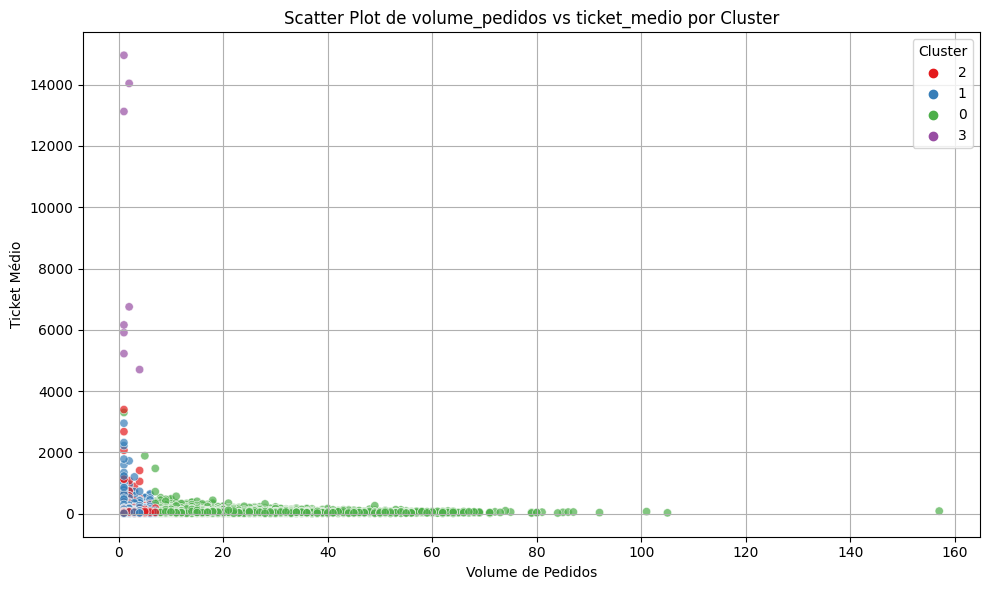

In [0]:
# 1. Carregar a base clusterizada salva no Delta Lake
df_clusters = spark.table("workspace.default.customer_clusters_pandas_sklearn").toPandas()

# 2. Garantir que o cluster seja interpretado como categoria (como em R)
df_clusters["cluster"] = df_clusters["cluster"].astype(str)

# 3. Criar o scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_clusters,
    x="volume_pedidos",
    y="ticket_medio",
    hue="cluster",
    palette="Set1",
    alpha=0.7
)
plt.title("Scatter Plot de volume_pedidos vs ticket_medio por Cluster")
plt.xlabel("Volume de Pedidos")
plt.ylabel("Ticket Médio")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

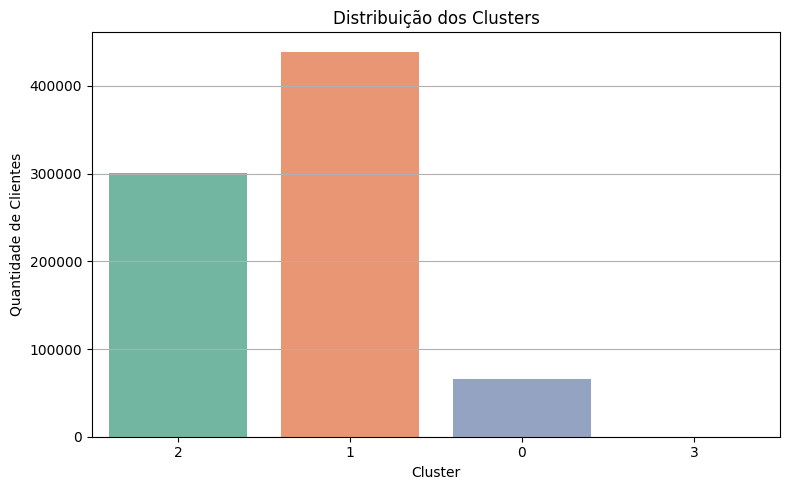

In [0]:
# Garantir que o cluster esteja como string para fins de visualização
df_clusters["cluster"] = df_clusters["cluster"].astype(str)

# Criar o bar plot
plt.figure(figsize=(8, 5))
sns.countplot(data=df_clusters, x="cluster", palette="Set2")
plt.title("Distribuição dos Clusters")
plt.xlabel("Cluster")
plt.ylabel("Quantidade de Clientes")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [0]:
df_clusters = spark.table("workspace.default.customer_clusters_pandas_sklearn")
df_result_order = spark.table("workspace.default.result_order")

# Faz o join para adicionar a coluna 'cluster' na base original
df_result_com_cluster = (
    df_result_order
    .join(df_clusters.select("customer_id_order", "cluster"), on="customer_id_order", how="left")
)

# Exibe a nova base com todas as colunas + cluster
display(df_result_com_cluster.limit(2))

df_result_com_cluster.write.mode("overwrite").option("overwriteSchema", "true").saveAsTable("workspace.default.result_order_cluster")

customer_id_order,cpf,customer_name,delivery_address_city,delivery_address_country,delivery_address_district,delivery_address_external_id,delivery_address_latitude,delivery_address_longitude,delivery_address_state,delivery_address_zip_code,merchant_id,merchant_latitude,merchant_longitude,merchant_timezone,order_created_at,order_id,order_scheduled,order_total_amount,origin_platform,item_name,item_addition_value,item_addition_currency,item_discount_value,item_discount_currency,item_quantity,item_sequence,item_unit_price_value,item_unit_price_currency,item_external_id,item_total_value_value,item_total_value_currency,item_customer_note,garnish_item_name,garnish_item_addition_value,garnish_item_addition_currency,garnish_item_discount_value,garnish_item_discount_currency,garnish_item_quantity,garnish_item_sequence,garnish_item_unit_price_value,garnish_item_unit_price_currency,garnish_item_category_id,garnish_item_external_id,garnish_item_total_value_value,garnish_item_total_value_currency,garnish_item_category_name,garnish_item_integration_id,customer_id_teste_ab,is_target,customer_id,language,consumer_created_at,active,customer_phone_area,customer_phone_number,restaurant_created_at,enabled,price_range,average_ticket,takeout_time,delivery_time,minimum_order_value,merchant_zip_code,merchant_city,merchant_state,merchant_country,cluster
35419c42dd9e77fa6b34811ef3cdf1f242255b6ab4aa62e936e4b1a2e5dd1952,24917797900,ULISSES,JUIZ DE FORA,BR,CASCATINHA,6760884,-43.36,-21.78,MG,36033,dd3915c8589797c626a80b506abf4ad85f7ff7fb3a2a61c865da0c3c834ac0bd,-43.36,-21.78,America/Sao_Paulo,2019-01-06T23:07:53.000Z,1b3f0287d7cc080e3060df78054ba251745a48e2dd6c25c296bd61957a4b6040,false,90.9,DESKTOP,403 Mariano Procópio,0,BRL,0,BRL,1.0,1,0,BRL,ee0f88c318af4612998392a0ead7b10c,0,BRL,null,AO PONTO,0,BRL,0,BRL,1.0,2,0,BRL,ASC2,82d8b31676374f889675a55ea1504796,0,BRL,PONTO DA CARNE,null,35419c42dd9e77fa6b34811ef3cdf1f242255b6ab4aa62e936e4b1a2e5dd1952,target,35419c42dd9e77fa6b34811ef3cdf1f242255b6ab4aa62e936e4b1a2e5dd1952,pt-br,2018-01-03T21:51:47.815Z,true,2,210686545,2017-01-20T13:14:31.214Z,false,5,100.0,0,50,0.0,36035,JUIZ DE FORA,MG,BR,1
35419c42dd9e77fa6b34811ef3cdf1f242255b6ab4aa62e936e4b1a2e5dd1952,24917797900,ULISSES,JUIZ DE FORA,BR,CASCATINHA,6760884,-43.36,-21.78,MG,36033,dd3915c8589797c626a80b506abf4ad85f7ff7fb3a2a61c865da0c3c834ac0bd,-43.36,-21.78,America/Sao_Paulo,2019-01-06T23:07:53.000Z,1b3f0287d7cc080e3060df78054ba251745a48e2dd6c25c296bd61957a4b6040,false,90.9,DESKTOP,403 Mariano Procópio,0,BRL,0,BRL,1.0,1,0,BRL,ee0f88c318af4612998392a0ead7b10c,0,BRL,null,Inteira,0,BRL,0,BRL,1.0,3,8290,BRL,AXUI,2dc5b08c22954891a931d4f3c6b63c73,8290,BRL,Tamanho,null,35419c42dd9e77fa6b34811ef3cdf1f242255b6ab4aa62e936e4b1a2e5dd1952,target,35419c42dd9e77fa6b34811ef3cdf1f242255b6ab4aa62e936e4b1a2e5dd1952,pt-br,2018-01-03T21:51:47.815Z,true,2,210686545,2017-01-20T13:14:31.214Z,false,5,100.0,0,50,0.0,36035,JUIZ DE FORA,MG,BR,1


In [0]:
df_orders = spark.table("workspace.default.result_order_cluster")

# Calculando métricas por cliente
df_metrics = (
    df_orders.groupBy("customer_id_order", "cluster", "delivery_address_state")
    .agg(
        F.countDistinct("order_id").alias("volume_pedidos"),
        F.avg("order_total_amount").alias("media_valor_pedido"),
        F.avg("price_range").alias("price_range_medio")
    )
)

# Agregando por cluster para obter médias
df_summary = (
    df_metrics.groupBy("cluster")
    .agg(
        F.countDistinct("customer_id_order").alias("usuarios_distintos"),
        F.round(F.avg("volume_pedidos"), 2).alias("volume_pedidos_medio"),
        F.round(F.avg("media_valor_pedido"), 2).alias("media_valor_pedido"),
        F.round(F.avg("price_range_medio"), 2).alias("price_range_medio")
    )
)

# Percentual por estado dentro de cada cluster
df_estado = (
    df_metrics.groupBy("cluster", "delivery_address_state")
    .agg(F.countDistinct("customer_id_order").alias("qtd_usuarios_estado"))
)

window_cluster = Window.partitionBy("cluster")

df_percentual_estado = (
    df_estado
    .withColumn("total_cluster", F.sum("qtd_usuarios_estado").over(window_cluster))
    .withColumn("percentual", F.round(F.col("qtd_usuarios_estado") / F.col("total_cluster") * 100, 2))
    .orderBy("cluster", F.desc("percentual"))
)


display(df_summary.where(F.col("cluster").isNotNull()))
# display(df_percentual_estado.where(F.col("cluster").isNotNull()))

cluster,usuarios_distintos,volume_pedidos_medio,media_valor_pedido,price_range_medio
1,439204,2.14,49.04,2.52
0,66033,12.07,52.71,2.66
2,301220,2.06,49.16,2.94
3,8,1.44,8740.92,3.67


**Abaixo estão as respostas do item 2, letras A e B.**

🟢 **Cluster 0 – Clientes Engajados**

- Usuários distintos: 66.033
- Volume médio de pedidos: 12,07
- Ticket médio: R$ 52,71
- Classificação de preço do restaurante (média): 2,66
- Distribuição geográfica: SP (39%) e RJ (23%) concentram mais de 60% dos usuários desse grupo. Presença considerável no Nordeste (ex: CE, PE) e MG.

Interpretação:
Esse é um grupo de clientes com alto engajamento (volume de pedidos significativamente superior aos demais) e ticket médio ligeiramente acima da média. Eles costumam consumir de restaurantes de preço intermediário para alto. Com forte presença em grandes centros urbanos, especialmente SP e RJ.

Perfil: Cliente fiel, potencial promotor da marca, com poder de compra moderado. Pode ser ideal para programas de fidelidade ou campanhas de cashback.

--------------------------


🔵 **Cluster 1 – Cliente Ocasional / Médio**

- Usuários distintos: 439.204
- Volume médio de pedidos: 2,14
- Ticket médio: R$ 49,04
- Classificação de preço do restaurante (média): 2,52
- Distribuição geográfica: Grande presença em SP, RJ e MG, mas mais disperso que o Cluster 0.

Interpretação:
Maior grupo da base. São clientes com baixo volume de pedidos, ticket próximo do valor médio e preferência por estabelecimentos de preço intermediário.

Perfil: Clientes ocasionais ou que usam o serviço em datas específicas. Pode ser interessante aplicar campanhas de reativação ou ofertas personalizadas para aumentar o LTV.

--------------------------

🔴 **Cluster 2 – Cliente Econômico**

- Usuários distintos: 301.220
- Volume médio de pedidos: 2,06
- Ticket médio: R$ 49,16
- Classificação de preço do restaurante (média): 2,94
- Também fortemente representado em SP e RJ, mas com leve viés para restaurantes mais caros.

Interpretação:
Também de baixa frequência, como o cluster 1, mas com preferência clara por restaurantes mais caros (faixa de preço média mais alta). Isso pode indicar usuários de ticket elevado pontual, como compras para grupos/família ou pedidos especiais.

Perfil: Clientes com poder aquisitivo maior, mas uso pouco frequente. Pode valer a pena explorar ofertas premium, parcerias com restaurantes de alta qualidade ou programas de indicações.

--------------------------

⚫ **Cluster 3 – Outliers / Clientes Corporativos**

- Usuários distintos: 8
- Volume médio de pedidos: 1,44
- Ticket médio: R$ 8.740,92
- Classificação de preço do restaurante (média): 3,67
- Distribuição geográfica: Não representativa

Interpretação:
Grupo muito pequeno e atípico. O valor médio do pedido é extremamente alto e a faixa de preço é elevada também. Isso sugere clientes corporativos ou erro de cadastro/registro.
Perfil: Provável outlier. Pode ser interessante remover da análise geral ou criar um segmento separado para análise especializada (B2B, eventos, etc.).


Resumindo, temos a seguinte proposta de teste com os grupos:
- Focar ações de fidelização e retenção no Cluster 0.
- Criar estratégias de reengajamento para Clusters 1 e 2, com diferenciação no tipo de benefício (econômico vs. premium).


In [0]:
df_orders = spark.table("workspace.default.result_order_cluster")

# Calculando métricas por cliente
df_metrics = (
    df_orders.groupBy("customer_id_order", "cluster", "delivery_address_state", "is_target")
    .agg(
        F.countDistinct("order_id").alias("volume_pedidos"),
        F.avg("order_total_amount").alias("media_valor_pedido"),
        F.avg("price_range").alias("price_range_medio")
    )
)

# Agregndo  por cluster e is_target para obter médias
df_summary = (
    df_metrics.groupBy("cluster", "is_target")
    .agg(
        F.countDistinct("customer_id_order").alias("usuarios_distintos"),
        F.round(F.avg("volume_pedidos"), 2).alias("volume_pedidos_medio"),
        F.round(F.avg("media_valor_pedido"), 2).alias("media_valor_pedido"),
        F.round(F.avg("price_range_medio"), 2).alias("price_range_medio")
    )
    .orderBy("cluster", "is_target")
)

# Percentual por estado dentro de cada cluster e is_target
df_estado = (
    df_metrics.groupBy("cluster", "is_target", "delivery_address_state")
    .agg(F.countDistinct("customer_id_order").alias("qtd_usuarios_estado"))
)

window_cluster_target = Window.partitionBy("cluster", "is_target")

df_percentual_estado = (
    df_estado
    .withColumn("total_cluster", F.sum("qtd_usuarios_estado").over(window_cluster_target))
    .withColumn("percentual", F.round(F.col("qtd_usuarios_estado") / F.col("total_cluster") * 100, 2))
    .orderBy("cluster", "is_target", F.desc("percentual"))
)


display(df_summary.where(F.col("cluster").isNotNull()))
# display(df_percentual_estado.where(F.col("cluster").isNotNull()).limit(10))


cluster,is_target,usuarios_distintos,volume_pedidos_medio,media_valor_pedido,price_range_medio
0,control,26476,12.05,52.9,2.65
0,target,39557,12.09,52.59,2.66
1,control,197858,2.01,48.79,2.51
1,target,241346,2.24,49.24,2.52
2,control,136203,1.94,49.05,2.95
2,target,165017,2.15,49.25,2.94
3,control,4,1.5,10020.41,3.75
3,target,4,1.4,7717.33,3.6


**Abaixo estão as respostas do item 2, letra C.**

🟢 **Cluster 0 – Usuários de alta frequência e ticket médio alto**
- Comportamento entre controle e target é praticamente idêntico.
- Controle: 12.05 pedidos | R$ 52.9 | Price range: 2.65
- Target: 12.09 pedidos | R$ 52.59 | Price range: 2.66

Interpretação: O cupom não teve efeito prático aqui. Esses usuários já compram muito e com frequência, mesmo sem incentivo.

Possível ação: Cupom pode ser desnecessário para este grupo. Avaliar estratégias mais sofisticadas, como programas de fidelidade.

-----------------------------

🔵 **Cluster 1 – Maior grupo, usuários de baixa frequência**
- Controle: 2.01 pedidos | R$ 48.79
- Target: 2.24 pedidos | R$ 49.24
- Aumento visível no volume de pedidos (coerente com o Wilcoxon).
- Ticket médio estável.

Interpretação: O cupom funcionou parcialmente aqui — aumentou o volume de pedidos, mas não o valor gasto.

Possível ação: Grupo mais sensível a incentivo → foco da campanha de cupom. Incentivar recorrência e ticket maior.

-----------------------------

🔴 **Cluster 2 – Similar ao cluster 1, mas com restaurantes mais caros**
- Controle: 1.94 pedidos | R$ 49.05 | Price range: 2.95
- Target: 2.15 pedidos | R$ 49.25 | Price range: 2.94
- Comportamento parecido com o cluster 1.
- Efeito do cupom também presente, mas levemente inferior.

Interpretação: Usuários que compram pouco e usam restaurantes de ticket mais alto.

Possível ação: Estratégia de cupom pode continuar, talvez com foco em promoções em restaurantes premium.

-----------------------------

⚫ **Cluster 3 – Outliers com ticket médio absurdamente alto**

4 usuários por grupo. Ticket médio > R$ 7.000. Não confiável para análise estatística. Ignorar ou tratar como outlier.

**Recomendação: Otimizar a distribuição dos cupons com base em segmentação de usuários**

A análise mostrou que o cupom não aumentou o ticket médio, mas gerou aumento significativo no volume de pedidos — especialmente entre usuários dos clusters 1 e 2, que representam mais de 85% da base total.

Resumo por cluster (segmento):
- 0:	Perfil: alta frequência | Ticket alto	| Efeito do cupom: nenhum |	Remover cupons e usar fidelidade
- 1: 	Perfil: baixa frequência | Ticket médio	|	Efeito do cupom: aumento de pedidos  |	Manter cupons, com foco em recorrência
- 2:	Perfil: baixa frequência | Restaurantes caros	|	Efeito do cupom: aumento de pedidos | Manter cupons, com foco em valor


**Impacto financeiro:**

Eficiência de campanha: ao focar onde o cupom funciona, melhora-se o ROI. Além disso, essa economia pode ser reinvestida para ampliar o incentivo nos clusters com maior resposta (1 e 2), gerando mais receita.

**Melhorias no processo/teste:**

- Redefinir os critérios de distribuição dos cupons, focando nos clusters 1 e 2.
- Testar novos valores de cupom por cluster. Exemplo: R$ 3 para cluster 1, e R$ 7 para cluster 2.
- Realizar novo teste A/B segmentado, com foco em validar o desempenho por cluster.

------------------------------------------------------------- FIM -------------------------------------------------------------